In [1]:
import os
from os.path import exists

import anchor
# import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *

In [2]:
data_path = "simulationVictorTopological/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-csr.csv"
feature_labels = ['meanEntropy', 'medianEntropy',
       'stdsEntropy', 'iqrsEntropy']
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"CP_SVM_safe.sav")

test = pd.read_csv(data_path+"test_cp.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)

In [3]:
test.describe()

,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.746932,2.748118,0.025853,0.035768,-0.352000,-0.384000
std,0.045338,0.046157,0.005938,0.010769,0.936468,0.923795
min,2.616961,2.618800,0.008000,0.000925,-1.000000,-1.000000
25%,2.722338,2.722738,0.021681,0.028700,-1.000000,-1.000000
50%,2.751815,2.753800,0.024910,0.034100,-1.000000,-1.000000
75%,2.784490,2.785200,0.028865,0.041125,1.000000,1.000000
max,2.831971,2.836900,0.050981,0.113600,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,medianEntropy > 2.75,0.5077,0.933444,-1.0,-1.0,-1.0
1,2,medianEntropy > 2.72,0.7532,0.790711,-1.0,-1.0,1.0
2,3,medianEntropy > 2.75,0.5003,0.952618,-1.0,-1.0,1.0
3,4,medianEntropy <= 2.72,0.2597,0.626717,1.0,1.0,1.0
4,5,medianEntropy <= 2.72,0.2520,0.619512,1.0,1.0,-1.0
...,...,...,...,...,...,...,...
534,992,meanEntropy > 2.78,0.2514,1.000000,-1.0,-1.0,-1.0
535,994,medianEntropy > 2.78,0.2514,1.000000,-1.0,-1.0,-1.0
536,995,medianEntropy > 2.78,0.2503,1.000000,-1.0,-1.0,-1.0
537,998,medianEntropy > 2.78,0.2404,1.000000,-1.0,-1.0,-1.0


In [5]:
rules["AnchorConditions"].value_counts()

AnchorConditions
medianEntropy <= 2.72                            160
medianEntropy <= 2.75 AND meanEntropy <= 2.75    106
medianEntropy > 2.78                              80
medianEntropy > 2.75                              58
meanEntropy <= 2.75 AND medianEntropy <= 2.75     35
medianEntropy > 2.72                              30
meanEntropy > 2.75                                23
iqrsEntropy > 0.04                                20
meanEntropy > 2.72                                 9
meanEntropy > 2.78                                 8
meanEntropy <= 2.72                                7
stdsEntropy > 0.03                                 1
iqrsEntropy > 0.03                                 1
stdsEntropy > 0.02                                 1
Name: count, dtype: int64

In [6]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
medianEntropy <= 2.72                            160
medianEntropy <= 2.75 AND meanEntropy <= 2.75    106
meanEntropy <= 2.75 AND medianEntropy <= 2.75     35
meanEntropy <= 2.72                                7
Name: count, dtype: int64

In [7]:
model.get_params()

{'alpha': array([ 4.99882127e-01, -9.15858789e-05,  4.99863490e-01, ...,
        -9.69180028e-05, -1.37421751e-04,  4.99954837e-01]),
 'b': array([-4.49645653]),
 'b_eps': 0.20106051501801608,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.2,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

# Candidate selection

Text(0, 0.5, 'Count')

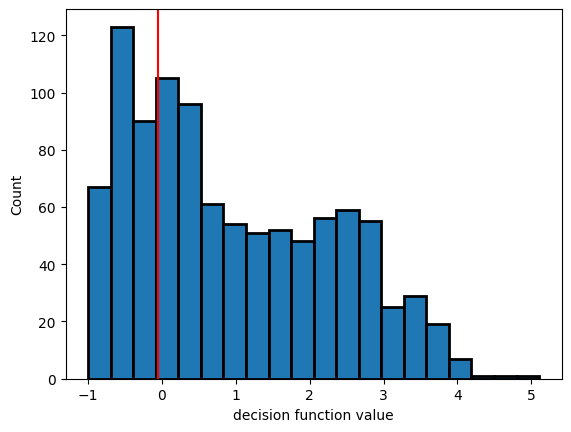

In [8]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [9]:
min(d_test)

-0.9938600924456551

In [10]:
max(d_test)

5.1044038497358954

In [11]:
model.b_eps

0.20106051501801608

In [12]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 20


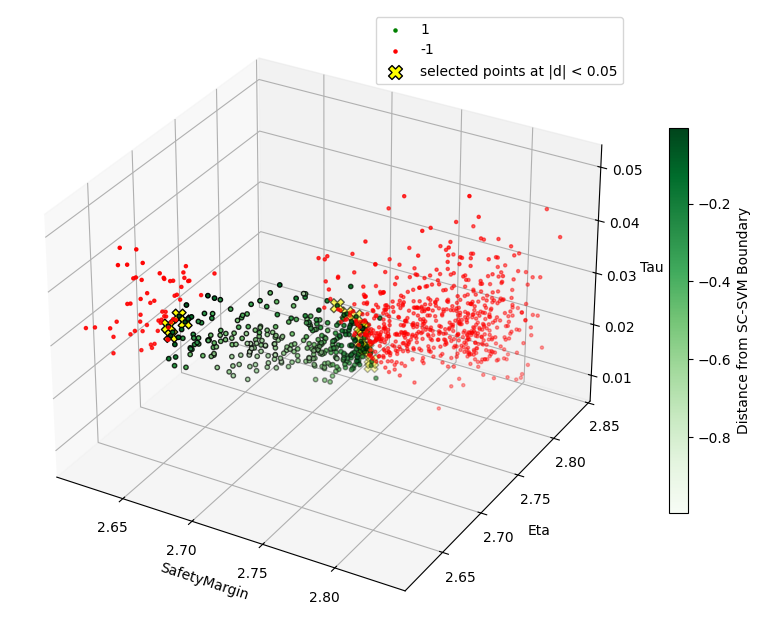

In [13]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

sc0 = ax.scatter3D(X_test[:,0][y_cp_test == -1], X_test[:,1][y_cp_test == -1], X_test[:,2][y_cp_test == -1], s=5, c= "red")
scsafe = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=5, c= "green")

sc1 = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1], cmap = "Greens", edgecolors = "k")

sc2 = ax.scatter3D(X_test[list(border_points_idx),0],X_test[list(border_points_idx),1], X_test[list(border_points_idx),2],s=100, marker = 'X', facecolors="yellow", edgecolors="k")


ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")
ax.set_zlabel("Tau")



ax.legend([scsafe, sc0,sc2], ["1","-1",f"selected points at |d| < {d_thresh}"], loc="upper right")
plt.colorbar(sc1, label = "Distance from SC-SVM Boundary", shrink = 0.5)

plt.show()

# Select the anchors for the candidate points

In [14]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [15]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [16]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
# '''
# # define a threshold for filtering on covering
# covering_threshold = 0.1

# rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

# rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

# rules_selected
# '''

In [17]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
medianEntropy <= 2.75 AND meanEntropy <= 2.75    14
medianEntropy <= 2.72                             4
meanEntropy <= 2.75 AND medianEntropy <= 2.75     2
Name: count, dtype: int64

# Performance Evaluation


In [18]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        err = fptot/(tntot+fptot)
        print(f"precision: {prec}, covering: {cov}, error: {err}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass

# SafetyMargin > 0.05 AND Tau <= 0.25 AND Eta > 0.25


In [19]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
4,5,medianEntropy <= 2.72,0.2520,0.619512,1.0,1.0,-1.0
92,157,medianEntropy <= 2.75 AND meanEntropy <= 2.75,0.4865,0.637714,1.0,1.0,1.0
184,338,meanEntropy <= 2.75 AND medianEntropy <= 2.75,0.4883,0.679400,1.0,1.0,1.0


# Evaluation on true labels

In [20]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: medianEntropy <= 2.72
tp = 125, tn = 568, fp = 108, fn = 199
precision: 0.5364806866952789, covering: 0.38580246913580246, error: 0.15976331360946747, accuracy: 0.693, f1: 0.4488330341113106

rule: medianEntropy <= 2.75 AND meanEntropy <= 2.75
tp = 271, tn = 494, fp = 182, fn = 53
precision: 0.5982339955849889, covering: 0.8364197530864198, error: 0.2692307692307692, accuracy: 0.765, f1: 0.6975546975546976

rule: meanEntropy <= 2.75 AND medianEntropy <= 2.75
tp = 271, tn = 494, fp = 182, fn = 53
precision: 0.5982339955849889, covering: 0.8364197530864198, error: 0.2692307692307692, accuracy: 0.765, f1: 0.6975546975546976



# evaluation on safety checker labels

In [21]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: medianEntropy <= 2.72
tp = 173, tn = 632, fp = 60, fn = 135
precision: 0.7424892703862661, covering: 0.5616883116883117, error: 0.08670520231213873, accuracy: 0.805, f1: 0.6395563770794824

rule: medianEntropy <= 2.75 AND meanEntropy <= 2.75
tp = 307, tn = 546, fp = 146, fn = 1
precision: 0.6777041942604857, covering: 0.9967532467532467, error: 0.21098265895953758, accuracy: 0.853, f1: 0.8068331143232589

rule: meanEntropy <= 2.75 AND medianEntropy <= 2.75
tp = 307, tn = 546, fp = 146, fn = 1
precision: 0.6777041942604857, covering: 0.9967532467532467, error: 0.21098265895953758, accuracy: 0.853, f1: 0.8068331143232589



**Evaluate the $\lor$ of the rules**

In [22]:
verified1 = (X_test[:,0] > 2.66) 

verified2 = (X_test[:,1] > 2.65) 

verified_or = verified1|verified2

prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")  

tp = 308, tn = 37, fp = 655, fn = 0
precision: 0.31983385254413293, covering: 1.0, accuracy: 0.345, f1: 0.4846577498033045, error: 0.6801661474558671
